# Simulate resting state dynamics in basic connectomes

First, we import all the required dependencies

In [1]:
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

INFO  log level set to INFO


## The Connectome

In order to built the mouse brain network we used a tracer-based connectome.

In particular we used a structural connectivity matrix (stored in the data folder of TVB), which is built thanks to the Allen Connectivity Builder in TVB.
The Allen Connectivity Builder is a tool that download and manipulate the open-source tracer experiments of the Allen Institute (Oh et al., 2014 [2]) in order to built a connectome and the corresponding parcelled volume according to the preferences of the user.

The user can choose:

  * the resolution of the grid volume in which the experimental data have been registered (here 100 $\mu m$).
  * The definition of the connection strength between source region $i$ and target region $j$. (here $w_{ij}=\frac{PD_j}{ID_i}$, where PD=projection density, ID=injection density)

It is possible to choose the characteristics of the brain areas to be included in the parcellation using the two following criteria:
 * Only brain areas where at least one injection has infected more than a given threshold of voxels. This kind of selection ensures that only the data with a certain level of experimental relevance is included in the connectome (Oh et al., 2014[2]), (here 50 voxels).
 * Only brain areas that have a volume greater than a given threshold can be included (here 2$mm^3$).



In the following the connectome is loaded in plotted. 
  

In [172]:
# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file(r"C:\Users\Pok Him\Desktop\paupau.zip")

WARNING  File 'hemispheres' not found in ZIP.


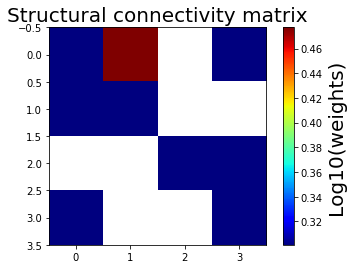

In [173]:
# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
#plt.yticks([0,1,2,3])

## The simulation

Once the brain network is defined is possible to simulate its activity. Here we simulate resting state dynamics using the reduced Wong Wang model (Deco et al. 2013 [3], Hansen et al., 2015 [4]).

In order to convert the synaptic activity in BOLD signals we used the Balloon-Windkessel method (Friston et al., 200 [5]) using the default value implemented in The Virtual Brain.

In [174]:
# Set the parameter of the resting state simulation
sim = simulator.Simulator(model=models.ReducedWongWang(w=1.0, I_o=0.3),
                        connectivity=con,
                        coupling=coupling.Linear(a=0.096),
                        integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=0.000013)),
                        monitors=(monitors.Bold(period=2e3),
                                  monitors.TemporalAverage(period=1e3)),
                        simulation_length=1.2e5).configure()
# Run the resting state simulation
(bold_time, bold_data), _ = sim.run()

The simulated bold signals can be visualized using matplotlib library.

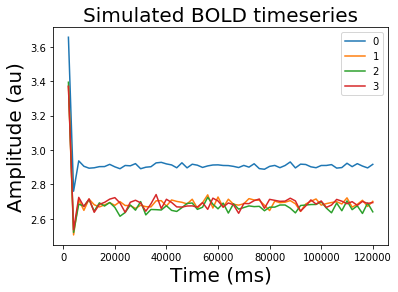

In [175]:
# Display the simulated bold timeseries
plt.subplots()
plt.plot(bold_time,bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)
plt.legend(('0','1','2','3'))


## Analysis

The simulated BOLD signals can be analyzed in different way. 

### Functional Connectivity Matrix

Let's just do a static one


In [176]:
# Calculate Functional Connectivity Matrix = Pearson_correlation between possible time series.
'''
# import tvb.analyzers.cross_correlation as cc1
import tvb.analyzers.correlation_coefficient as cc2 
from tvb.datatypes.time_series import TimeSeriesRegion

# Build the time series object
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data)
tsr.configure()


# CC1 = cc1.CrossCorrelate(time_series = tsr)
CC2 = cc2.CorrelationCoefficient(time_series = tsr, t_start = 1e4, t_end = 1.2e5)

Cc3 = CC2.evaluate()
plt.imshow(Cc3)
'''

'\n# import tvb.analyzers.cross_correlation as cc1\nimport tvb.analyzers.correlation_coefficient as cc2 \nfrom tvb.datatypes.time_series import TimeSeriesRegion\n\n# Build the time series object\ntsr = TimeSeriesRegion(connectivity=sim.connectivity,\n                       data=bold_data)\ntsr.configure()\n\n\n# CC1 = cc1.CrossCorrelate(time_series = tsr)\nCC2 = cc2.CorrelationCoefficient(time_series = tsr, t_start = 1e4, t_end = 1.2e5)\n\nCc3 = CC2.evaluate()\nplt.imshow(Cc3)\n'

In [177]:
# Functional Connectivity Matrix. 

# Time series 0 
# bold_data[:,0,0].flatten()

# numpy.corrcoef(bold_data[:,0,0].flatten(),bold_data[:,0,1].flatten())
# Matrix = [bold_data[:,0,0].flatten(),bold_data[:,0,1].flatten(),bold_data[:,0,2].flatten(),bold_data[:,0,3].flatten()]

# Convert Simulation output into a form usable by Numpy.
TSeriesMatrix = np.empty((bold_data.shape[2], bold_data.shape[0]-5))
#Matrix = []

for i in range(bold_data.shape[2]):
    TSeriesMatrix[i] = bold_data[5:,0,i].flatten()

# Functional Conenctivity MAtrix = Pearson Correlation.

FCM = np.corrcoef(TSeriesMatrix)
FCM

array([[1.        , 0.11950961, 0.06339408, 0.11436891],
       [0.11950961, 1.        , 0.06693635, 0.14174641],
       [0.06339408, 0.06693635, 1.        , 0.12869134],
       [0.11436891, 0.14174641, 0.12869134, 1.        ]])

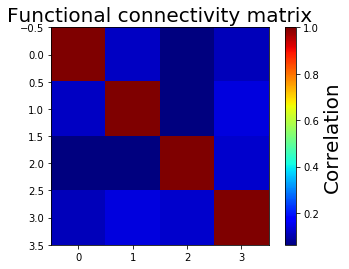

In [178]:
# Plot Matrix
cs=plt.imshow(FCM, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

In [179]:
## Set the parameter of the resting state simulation
sim_non= simulator.Simulator(model=models.ReducedWongWang(w=1.0, I_o=0.3),
                        connectivity=con,
                        coupling=coupling.Linear(a=0.096),
                        integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=0.000013)),
                        monitors=(monitors.TemporalAverage(period=1e3)),
                        simulation_length=1.2e5).configure()
# Run the resting state simulation
(non_bold_time, non_bold_data), _ = sim_non.run()

In [ ]:
awer = sim_non.run()

In [ ]:
non_bold_time = awer[0][0]
non_bold_data = awer[0][1]

In [ ]:
# Display the simulated non-bold timeseries
plt.subplots()
plt.plot(non_bold_time,non_bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated non-BOLD timeseries', fontsize=20)
plt.legend(('0','1','2','3'))

In [ ]:
# Convert Simulation output into a form usable by Numpy.
TSeriesMatrix = np.empty((non_bold_data.shape[2], non_bold_data.shape[0]))
#Matrix = []

for i in range(non_bold_data.shape[2]):
    TSeriesMatrix[i] = non_bold_data[:,0,i].flatten()

# Functional Conenctivity MAtrix = Pearson Correlation.

FCM = np.corrcoef(TSeriesMatrix)
FCM

In [ ]:
# Plot Matrix
cs=plt.imshow(FCM, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])